## All Imports

In [96]:
import os
import pandas as pd
import numpy as np

from sklearn.preprocessing import OneHotEncoder,LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.metrics import accuracy_score
from sklearn.feature_selection import RFE, SelectKBest, chi2, SelectFromModel
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split

from collections import defaultdict

import pandas.core.algorithms as algos
import scipy.stats.stats as stats
import re
import traceback
import string

from pandas import Series

from collections import defaultdict
from functools import reduce
from statsmodels.stats.outliers_influence import variance_inflation_factor

## Create needed functions

In [97]:
max_bin = 20
force_bin = 3

# define a binning function
def mono_bin(Y, X, n = max_bin):
    
    df1 = pd.DataFrame({"X": X, "Y": Y})
    justmiss = df1[['X','Y']][df1.X.isnull()]
    notmiss = df1[['X','Y']][df1.X.notnull()]
    r = 0
    while np.abs(r) < 1:
        try:
            d1 = pd.DataFrame({"X": notmiss.X, "Y": notmiss.Y, "Bucket": pd.qcut(notmiss.X, n)})
            d2 = d1.groupby('Bucket', as_index=True)
            r, p = stats.spearmanr(d2.mean().X, d2.mean().Y)
            n = n - 1 
        except Exception as e:
            n = n - 1

    if len(d2) == 1:
        n = force_bin         
        bins = algos.quantile(notmiss.X, np.linspace(0, 1, n))
        if len(np.unique(bins)) == 2:
            bins = np.insert(bins, 0, 1)
            bins[1] = bins[1]-(bins[1]/2)
        d1 = pd.DataFrame({"X": notmiss.X, "Y": notmiss.Y, "Bucket": pd.cut(notmiss.X, np.unique(bins),include_lowest=True)}) 
        d2 = d1.groupby('Bucket', as_index=True)
    
    d3 = pd.DataFrame({},index=[])
    d3["MIN_VALUE"] = d2.min().X
    d3["MAX_VALUE"] = d2.max().X
    d3["COUNT"] = d2.count().Y
    d3["EVENT"] = d2.sum().Y
    d3["NONEVENT"] = d2.count().Y - d2.sum().Y
    d3=d3.reset_index(drop=True)
    
    if len(justmiss.index) > 0:
        d4 = pd.DataFrame({'MIN_VALUE':np.nan},index=[0])
        d4["MAX_VALUE"] = np.nan
        d4["COUNT"] = justmiss.count().Y
        d4["EVENT"] = justmiss.sum().Y
        d4["NONEVENT"] = justmiss.count().Y - justmiss.sum().Y
        d3 = d3.append(d4,ignore_index=True)
    
    d3["EVENT_RATE"] = d3.EVENT/d3.COUNT
    d3["NON_EVENT_RATE"] = d3.NONEVENT/d3.COUNT
    d3["DIST_EVENT"] = d3.EVENT/d3.sum().EVENT
    d3["DIST_NON_EVENT"] = d3.NONEVENT/d3.sum().NONEVENT
    d3["WOE"] = np.log(d3.DIST_EVENT/d3.DIST_NON_EVENT)
    d3["IV"] = (d3.DIST_EVENT-d3.DIST_NON_EVENT)*np.log(d3.DIST_EVENT/d3.DIST_NON_EVENT)
    d3["VAR_NAME"] = "VAR"
    d3 = d3[['VAR_NAME','MIN_VALUE', 'MAX_VALUE', 'COUNT', 'EVENT', 'EVENT_RATE', 'NONEVENT', 'NON_EVENT_RATE', 'DIST_EVENT','DIST_NON_EVENT','WOE', 'IV']]       
    d3 = d3.replace([np.inf, -np.inf], 0)
    d3.IV = d3.IV.sum()
    
    return(d3)

def char_bin(Y, X):
        
    df1 = pd.DataFrame({"X": X, "Y": Y})
    justmiss = df1[['X','Y']][df1.X.isnull()]
    notmiss = df1[['X','Y']][df1.X.notnull()]    
    df2 = notmiss.groupby('X',as_index=True)
    
    d3 = pd.DataFrame({},index=[])
    d3["COUNT"] = df2.count().Y
    d3["MIN_VALUE"] = df2.sum().Y.index
    d3["MAX_VALUE"] = d3["MIN_VALUE"]
    d3["EVENT"] = df2.sum().Y
    d3["NONEVENT"] = df2.count().Y - df2.sum().Y
    
    if len(justmiss.index) > 0:
        d4 = pd.DataFrame({'MIN_VALUE':np.nan},index=[0])
        d4["MAX_VALUE"] = np.nan
        d4["COUNT"] = justmiss.count().Y
        d4["EVENT"] = justmiss.sum().Y
        d4["NONEVENT"] = justmiss.count().Y - justmiss.sum().Y
        d3 = d3.append(d4,ignore_index=True)
    
    d3["EVENT_RATE"] = d3.EVENT/d3.COUNT
    d3["NON_EVENT_RATE"] = d3.NONEVENT/d3.COUNT
    d3["DIST_EVENT"] = d3.EVENT/d3.sum().EVENT
    d3["DIST_NON_EVENT"] = d3.NONEVENT/d3.sum().NONEVENT
    d3["WOE"] = np.log(d3.DIST_EVENT/d3.DIST_NON_EVENT)
    d3["IV"] = (d3.DIST_EVENT-d3.DIST_NON_EVENT)*np.log(d3.DIST_EVENT/d3.DIST_NON_EVENT)
    d3["VAR_NAME"] = "VAR"
    d3 = d3[['VAR_NAME','MIN_VALUE', 'MAX_VALUE', 'COUNT', 'EVENT', 'EVENT_RATE', 'NONEVENT', 'NON_EVENT_RATE', 'DIST_EVENT','DIST_NON_EVENT','WOE', 'IV']]      
    d3 = d3.replace([np.inf, -np.inf], 0)
    d3.IV = d3.IV.sum()
    d3 = d3.reset_index(drop=True)
    
    return(d3)

def data_vars(df1, target):
    
    stack = traceback.extract_stack()
    filename, lineno, function_name, code = stack[-2]
    vars_name = re.compile(r'\((.*?)\).*$').search(code).groups()[0]
    final = (re.findall(r"[\w']+", vars_name))[-1]
    
    x = df1.dtypes.index
    count = -1
    
    for i in x:
        if i.upper() not in (final.upper()):
            if np.issubdtype(df1[i], np.number) and len(Series.unique(df1[i])) > 2:
                conv = mono_bin(target, df1[i])
                conv["VAR_NAME"] = i
                count = count + 1
            else:
                conv = char_bin(target, df1[i])
                conv["VAR_NAME"] = i            
                count = count + 1
                
            if count == 0:
                iv_df = conv
            else:
                iv_df = iv_df.append(conv,ignore_index=True)
    
    iv = pd.DataFrame({'IV':iv_df.groupby('VAR_NAME').IV.max()})
    iv = iv.reset_index()
    return(iv_df,iv)

def calculate_vif(features):
    vif = pd.DataFrame()
    vif["Features"] = features.columns
    vif["VIF"] = [variance_inflation_factor(features.values, i) for i in range(features.shape[1])]    
    return(vif)


## Start with Variable selection

In [98]:
df = pd.read_csv('Data\\JV01_Tymebank_Combined_DS_20191006_Sampled_2.zip',sep="|") #Read excel file
df = df[df.columns.difference(['MS_ID','NEWID'])]
df['Target'] = df['Target'].apply(lambda x : 1 if x == 'Y' else 0)  # Convert to numeric
df.drop(['PHYSICAL_ADDRESS_EA_CODE','PHYSICAL_ADDRESS_POSTCODE','PHYSICAL_ADDRESS_RECENCY', 'PHYSICAL_ADDRESS_TOTAL_SHARE','PHYSICAL_ADDRESS_DELIVERY_STATUS', 'PHYSICAL_ADDRESS_HAS','PHYSICAL_ADDRESS_REGION', 'PHYSICAL_ADDRESS_SUBURB','PHYSICAL_ADDRESS_TOWN'], inplace=True, axis=1)
df.drop(['Deeds_FirstProp_BondActiveInd', 'Deeds_FirstProp_Latest_BondAmount',
       'Deeds_FirstProp_NUM_OWNERS', 'Deeds_FirstProp_Number_Bonds_All',
       'Deeds_FirstProp_Number_Bonds_Secondary',
       'Deeds_FirstProp_Number_Bonds_Switches', 'Deeds_FirstProp_Purch_Price'], inplace=True, axis=1)
df.drop(['GLX_DISTRICT',
         'GLX_PROVINCE',
         'GLX_TOWN'], inplace=True, axis=1)
df.head()

C:\Users\C61166A\AppData\Local\Continuum\miniconda3\envs\ds_full\lib\site-packages\IPython\core\interactiveshell.py:3058: DtypeWarning: Columns (58) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,AGE_GRP,ALL_AO5Years,ALL_NUMBER_OF_TIMES_TARGETED_12M,ALL_NUMBER_OF_TIMES_TARGETED_24M,ALL_NUMBER_OF_TIMES_TARGETED_3M,ALL_NUMBER_OF_TIMES_TARGETED_6M,APP_Age_YY,APP_Gender,AgeAtMarriage,Area_AffluenceIndex_Final,...,OTH_NUMBER_OF_TIMES_TARGETED_12M,OTH_NUMBER_OF_TIMES_TARGETED_24M,OTH_NUMBER_OF_TIMES_TARGETED_3M,OTH_NUMBER_OF_TIMES_TARGETED_6M,Pix_DemogBasic,Pix_GenderAge,RDC_PHYSICAL_EA_CODE,Target,Wealth_Index_v2,YearsMarried_Grp
0,26-30,!,4,9,1,2,26,M,-4,9,...,1,1,1,1,DN40,GA3,NaN,0,2,NaN
1,26-30,N,11,18,4,7,29,F,-4,-4,...,8,9,3,5,DN100,GA15,NaN,0,2,NaN
2,26-30,$,5,8,2,3,28,F,-4,2,...,1,1,1,1,DN100,GA15,NaN,0,2,NaN
3,<=20,N,2,2,1,1,20,F,-4,-4,...,2,2,1,1,DN98,GA13,NaN,1,2,NaN
4,31-35,N,5,7,2,3,35,F,-4,9,...,1,1,1,1,DN101,GA16,NaN,0,2,NaN


In [99]:
df.columns

Index(['AGE_GRP', 'ALL_AO5Years', 'ALL_NUMBER_OF_TIMES_TARGETED_12M',
       'ALL_NUMBER_OF_TIMES_TARGETED_24M', 'ALL_NUMBER_OF_TIMES_TARGETED_3M',
       'ALL_NUMBER_OF_TIMES_TARGETED_6M', 'APP_Age_YY', 'APP_Gender',
       'AgeAtMarriage', 'Area_AffluenceIndex_Final', 'BTS_CELL_PHONE_1_HAS',
       'BTS_CELL_PHONE_1_PROVIDER', 'BTS_CELL_PHONE_1_QUALITY',
       'BTS_CELL_PHONE_1_RECENCY', 'BTS_CELL_PHONE_1_SHARING',
       'BTS_TOTALVALIDTEL', 'CIPC_Avg_MemberSize', 'CIPC_DirectorInd_Final',
       'CIPC_Max_MemberSize', 'CIPC_Min_MemberSize',
       'CIPC_NumberOfFoundedCompaniesEver', 'CIPC_Sum_MemberSize',
       'Deceased_Final', 'DeedsInd_Final', 'Deeds_Active_LatestPurchaseDate',
       'Deeds_Active_MaxPurchasePrice', 'Deeds_Active_TotalProperties',
       'DigitallyEnabledInd_Final', 'EverDivorced_Ind', 'FINAL_EMAIL_HAS',
       'FINAL_EMAIL_RANK', 'Farm_Ind', 'House_AffluenceIndex_Final',
       'JUD_Tot_Ever', 'Land_Ind', 'LivingBelowTheBreadLine_Ind',
       'Married_Final

In [100]:
df.RDC_PHYSICAL_EA_CODE.value_counts()

79714941.0    3500
59913899.0    2125
79913060.0    2014
59912448.0    1888
59910424.0    1361
              ... 
79812608.0       1
26810123.0       1
79811503.0       1
47810299.0       1
79912045.0       1
Name: RDC_PHYSICAL_EA_CODE, Length: 17145, dtype: int64

## Fix Missing Values for Categoricle vars

In [101]:
print(df.dtypes)

AGE_GRP                               object
ALL_AO5Years                          object
ALL_NUMBER_OF_TIMES_TARGETED_12M       int64
ALL_NUMBER_OF_TIMES_TARGETED_24M       int64
ALL_NUMBER_OF_TIMES_TARGETED_3M        int64
ALL_NUMBER_OF_TIMES_TARGETED_6M        int64
APP_Age_YY                             int64
APP_Gender                            object
AgeAtMarriage                          int64
Area_AffluenceIndex_Final              int64
BTS_CELL_PHONE_1_HAS                  object
BTS_CELL_PHONE_1_PROVIDER             object
BTS_CELL_PHONE_1_QUALITY              object
BTS_CELL_PHONE_1_RECENCY               int64
BTS_CELL_PHONE_1_SHARING               int64
BTS_TOTALVALIDTEL                      int64
CIPC_Avg_MemberSize                  float64
CIPC_DirectorInd_Final                 int64
CIPC_Max_MemberSize                  float64
CIPC_Min_MemberSize                  float64
CIPC_NumberOfFoundedCompaniesEver      int64
CIPC_Sum_MemberSize                  float64
Deceased_F

In [102]:
numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']

features_numeric = df.select_dtypes(include=numerics)
features_categoric = df.select_dtypes(include=['object'])


In [103]:
features_categoric_imp = features_categoric.fillna("")
del features_categoric

In [104]:
features_numeric_imp= features_numeric.fillna(features_numeric.mean())
del features_numeric

## Label Encoding

In [105]:
d = defaultdict(LabelEncoder)

features_categoric_imp = features_categoric_imp.select_dtypes(include=['object']).apply(lambda x: d[x.name].fit_transform(x))

features_categoric_imp

,AGE_GRP,ALL_AO5Years,APP_Gender,BTS_CELL_PHONE_1_HAS,BTS_CELL_PHONE_1_PROVIDER,BTS_CELL_PHONE_1_QUALITY,Deceased_Final,DeedsInd_Final,Deeds_Active_LatestPurchaseDate,DigitallyEnabledInd_Final,EverDivorced_Ind,FINAL_EMAIL_HAS,FINAL_EMAIL_RANK,Married_Final,NonCredit_FASType_v1,NonCredit_LSM_Prediction_v1,Pix_DemogBasic,Pix_GenderAge,YearsMarried_Grp
0,1,0,1,1,2,4,0,0,7292,0,0,0,0,0,13,3,27,15,0
1,1,2,0,1,1,3,0,0,7292,0,0,0,0,0,19,1,1,5,0
2,1,1,0,1,4,2,0,0,7292,0,0,0,0,0,19,3,1,5,0
3,10,2,0,1,4,1,0,0,7292,0,0,0,0,0,20,1,58,3,0
4,2,2,0,1,4,2,0,0,7292,0,0,0,0,0,17,3,2,6,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
124320,6,2,1,1,4,1,0,0,7292,0,0,1,5,0,5,3,32,20,0
124321,2,0,1,1,2,4,0,0,7292,0,0,0,0,0,9,3,28,16,0
124322,5,2,0,1,4,1,0,0,7292,0,0,1,5,0,16,3,5,9,0
124323,4,2,1,1,4,1,0,0,7292,0,0,1,4,0,11,3,30,18,0


In [106]:
df = features_numeric_imp.join(features_categoric_imp)

In [107]:
features = df[df.columns.difference(['Target'])]
labels = df['Target']

# Start Variable Selections Process

## WOE

In [108]:
final_iv, IV = data_vars(df,df.Target)
IV = IV.rename(columns={'VAR_NAME':'index'})

C:\Users\C61166A\AppData\Local\Continuum\miniconda3\envs\ds_full\lib\site-packages\pandas\core\series.py:853: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [109]:
final_iv

,VAR_NAME,MIN_VALUE,MAX_VALUE,COUNT,EVENT,EVENT_RATE,NONEVENT,NON_EVENT_RATE,DIST_EVENT,DIST_NON_EVENT,WOE,IV
0,ALL_NUMBER_OF_TIMES_TARGETED_12M,1.0,6.0,51697,9859,0.190707,41838,0.809293,0.396709,0.420597,-0.058472,0.002605
1,ALL_NUMBER_OF_TIMES_TARGETED_12M,7.0,10.0,33018,6696,0.202798,26322,0.797202,0.269435,0.264615,0.018053,0.002605
2,ALL_NUMBER_OF_TIMES_TARGETED_12M,11.0,95.0,39610,8297,0.209467,31313,0.790533,0.333856,0.314789,0.058809,0.002605
3,ALL_NUMBER_OF_TIMES_TARGETED_24M,1.0,15.0,65841,13399,0.203505,52442,0.796495,0.539152,0.527198,0.022420,0.000574
4,ALL_NUMBER_OF_TIMES_TARGETED_24M,16.0,152.0,58484,11453,0.195831,47031,0.804169,0.460848,0.472802,-0.025607,0.000574
...,...,...,...,...,...,...,...,...,...,...,...,...
107,Pix_DemogBasic,28.0,59.0,54162,10610,0.195894,43552,0.804106,0.426927,0.437827,-0.025211,0.000484
108,Pix_GenderAge,0.0,11.0,64584,12140,0.187972,52444,0.812028,0.488492,0.527218,-0.076292,0.006003
109,Pix_GenderAge,12.0,21.0,59741,12712,0.212785,47029,0.787215,0.511508,0.472782,0.078730,0.006003
110,YearsMarried_Grp,0.0,1.0,115754,23659,0.204390,92095,0.795610,0.951996,0.925829,0.027871,0.012114


In [110]:
IV.sort_values(['IV'],ascending=0).head(20)

,index,IV
23,DeedsInd_Final,0.173119
34,Land_Ind,0.151777
26,Deeds_Active_TotalProperties,0.151777
25,Deeds_Active_MaxPurchasePrice,0.151777
32,House_AffluenceIndex_Final,0.149223
47,Wealth_Index_v2,0.093537
6,APP_Age_YY,0.066611
0,AGE_GRP,0.057385
9,Area_AffluenceIndex_Final,0.034400
7,APP_Gender,0.025342


## Variable Importance

In [111]:
clf = RandomForestClassifier(n_estimators=100)

clf.fit(features,labels)

preds = clf.predict(features)

VI = pd.DataFrame(clf.feature_importances_, columns = ["RF"], index=features.columns)

VI = VI.reset_index()

VI.sort_values(['RF'],ascending=0)

,index,RF
42,OTH_NUMBER_OF_TIMES_TARGETED_3M,0.112808
46,RDC_PHYSICAL_EA_CODE,0.099762
3,ALL_NUMBER_OF_TIMES_TARGETED_24M,0.070096
6,APP_Age_YY,0.057275
2,ALL_NUMBER_OF_TIMES_TARGETED_12M,0.056359
13,BTS_CELL_PHONE_1_RECENCY,0.047474
5,ALL_NUMBER_OF_TIMES_TARGETED_6M,0.044031
41,OTH_NUMBER_OF_TIMES_TARGETED_24M,0.041788
4,ALL_NUMBER_OF_TIMES_TARGETED_3M,0.040984
9,Area_AffluenceIndex_Final,0.034323


## Recursive Feature Elimination

In [112]:
model = LogisticRegression(solver='lbfgs')
rfe = RFE(model, 20)
fit = rfe.fit(features, labels)

Selected = pd.DataFrame(rfe.support_, columns = ["RFE"], index=features.columns)
Selected = Selected.reset_index()

Selected[Selected['RFE'] == True]

,index,RFE
0,AGE_GRP,True
2,ALL_NUMBER_OF_TIMES_TARGETED_12M,True
3,ALL_NUMBER_OF_TIMES_TARGETED_24M,True
4,ALL_NUMBER_OF_TIMES_TARGETED_3M,True
5,ALL_NUMBER_OF_TIMES_TARGETED_6M,True
6,APP_Age_YY,True
9,Area_AffluenceIndex_Final,True
13,BTS_CELL_PHONE_1_RECENCY,True
21,CIPC_Sum_MemberSize,True
24,Deeds_Active_LatestPurchaseDate,True


## Variable Importance - Extratrees Classifier

In [113]:
model = ExtraTreesClassifier()
model.fit(features, labels)

FI = pd.DataFrame(model.feature_importances_, columns = ["Extratrees"], index=features.columns)

FI = FI.reset_index()

FI.sort_values(['Extratrees'],ascending=0)

C:\Users\C61166A\AppData\Local\Continuum\miniconda3\envs\ds_full\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


,index,Extratrees
42,OTH_NUMBER_OF_TIMES_TARGETED_3M,0.097783
46,RDC_PHYSICAL_EA_CODE,0.071407
3,ALL_NUMBER_OF_TIMES_TARGETED_24M,0.060756
2,ALL_NUMBER_OF_TIMES_TARGETED_12M,0.057681
6,APP_Age_YY,0.052727
13,BTS_CELL_PHONE_1_RECENCY,0.051201
4,ALL_NUMBER_OF_TIMES_TARGETED_3M,0.050817
5,ALL_NUMBER_OF_TIMES_TARGETED_6M,0.049613
41,OTH_NUMBER_OF_TIMES_TARGETED_24M,0.047310
14,BTS_CELL_PHONE_1_SHARING,0.041756


## Chi Square

In [114]:
df1 = df.copy()

d = defaultdict(LabelEncoder)
# Encoding the categorical variable
fit = df1.apply(lambda x: d[x.name].fit_transform(x))

#Convert the categorical columns based on encoding
for i in list(d.keys()):
    df1[i] = d[i].transform(df1[i])
    
features1 = df1[df1.columns.difference(['Target'])]
labels1 = df1['Target']

model = SelectKBest(score_func=chi2, k=5)
fit = model.fit(features1, labels1)

chi_sq = pd.DataFrame(fit.scores_, columns = ["Chi_Square"], index=features1.columns)

chi_sq = chi_sq.reset_index()

chi_sq.sort_values('Chi_Square',ascending=0)

,index,Chi_Square
25,Deeds_Active_MaxPurchasePrice,4.121661e+06
46,RDC_PHYSICAL_EA_CODE,4.260777e+05
24,Deeds_Active_LatestPurchaseDate,3.429876e+05
6,APP_Age_YY,7.342437e+03
47,Wealth_Index_v2,6.763966e+03
21,CIPC_Sum_MemberSize,5.878373e+03
13,BTS_CELL_PHONE_1_RECENCY,3.771630e+03
32,House_AffluenceIndex_Final,3.516787e+03
16,CIPC_Avg_MemberSize,3.383844e+03
8,AgeAtMarriage,2.842687e+03


## L1 feature selection

In [115]:
lsvc = LinearSVC(C=0.01, penalty="l1", dual=False).fit(features, labels)
model = SelectFromModel(lsvc,prefit=True)

l1 = pd.DataFrame(model.get_support(), columns = ["L1"], index=features.columns)

l1 = l1.reset_index()

l1[l1['L1'] == True]

,index,L1
0,AGE_GRP,True
1,ALL_AO5Years,True
2,ALL_NUMBER_OF_TIMES_TARGETED_12M,True
3,ALL_NUMBER_OF_TIMES_TARGETED_24M,True
4,ALL_NUMBER_OF_TIMES_TARGETED_3M,True
5,ALL_NUMBER_OF_TIMES_TARGETED_6M,True
6,APP_Age_YY,True
7,APP_Gender,True
8,AgeAtMarriage,True
9,Area_AffluenceIndex_Final,True


# Combined all 6

In [116]:
dfs = [IV, VI, Selected, FI, chi_sq, l1]
final_results = reduce(lambda left,right: pd.merge(left,right,on='index'), dfs)
final_results.head()

,index,IV,RF,RFE,Extratrees,Chi_Square,L1
0,AGE_GRP,0.057385,0.017309,True,0.016252,1818.008783,True
1,ALL_AO5Years,0.000289,0.004937,False,0.005803,22.676204,True
2,ALL_NUMBER_OF_TIMES_TARGETED_12M,0.002605,0.056359,True,0.057681,2.295628,True
3,ALL_NUMBER_OF_TIMES_TARGETED_24M,0.000574,0.070096,True,0.060756,1656.528147,True
4,ALL_NUMBER_OF_TIMES_TARGETED_3M,0.006196,0.040984,True,0.050817,677.457453,True


# Variable Scores

In [117]:
columns = ['IV', 'RF', 'Extratrees', 'Chi_Square']

score_table = pd.DataFrame({},[])
score_table['index'] = final_results['index']

for i in columns:
    score_table[i] = final_results['index'].isin(list(final_results.nlargest(5,i)['index'])).astype(int)
    
score_table['RFE'] = final_results['RFE'].astype(int)
score_table['L1'] = final_results['L1'].astype(int)

In [118]:
score_table['final_score'] = score_table.sum(axis=1)
score_table.sort_values('final_score',ascending=0).head(20)

,index,IV,RF,Extratrees,Chi_Square,RFE,L1,final_score
6,APP_Age_YY,0,1,1,1,1,1,5
2,ALL_NUMBER_OF_TIMES_TARGETED_12M,0,1,1,0,1,1,4
3,ALL_NUMBER_OF_TIMES_TARGETED_24M,0,1,1,0,1,1,4
46,RDC_PHYSICAL_EA_CODE,0,1,1,1,1,0,4
24,Deeds_Active_LatestPurchaseDate,0,0,0,1,1,1,3
34,Land_Ind,1,0,0,0,1,1,3
25,Deeds_Active_MaxPurchasePrice,1,0,0,1,1,0,3
26,Deeds_Active_TotalProperties,1,0,0,0,1,1,3
42,OTH_NUMBER_OF_TIMES_TARGETED_3M,0,1,1,0,0,1,3
47,Wealth_Index_v2,0,0,0,1,1,1,3


In [119]:
features = features[list(score_table[score_table['final_score'] >= 2]['index'])]

vif = calculate_vif(features)
while vif['VIF'][vif['VIF'] > 10].any():
    remove = vif.sort_values('VIF',ascending=0)['Features'][:1]
    features.drop(remove,axis=1,inplace=True)
    vif = calculate_vif(features)
    
list(vif['Features'])

['AGE_GRP',
 'ALL_NUMBER_OF_TIMES_TARGETED_3M',
 'Area_AffluenceIndex_Final',
 'BTS_CELL_PHONE_1_RECENCY',
 'CIPC_Sum_MemberSize',
 'DeedsInd_Final',
 'Deeds_Active_MaxPurchasePrice',
 'Deeds_Active_TotalProperties',
 'House_AffluenceIndex_Final',
 'NonCredit_FASType_v1',
 'OTH_NUMBER_OF_TIMES_TARGETED_24M',
 'OTH_NUMBER_OF_TIMES_TARGETED_3M',
 'Pix_DemogBasic',
 'Pix_GenderAge',
 'RDC_PHYSICAL_EA_CODE',
 'Wealth_Index_v2']

In [120]:
final_vars = list(vif['Features']) + ['Target']

In [121]:
df1 = df[final_vars].fillna(0)
df1.describe()

,AGE_GRP,ALL_NUMBER_OF_TIMES_TARGETED_3M,Area_AffluenceIndex_Final,BTS_CELL_PHONE_1_RECENCY,CIPC_Sum_MemberSize,DeedsInd_Final,Deeds_Active_MaxPurchasePrice,Deeds_Active_TotalProperties,House_AffluenceIndex_Final,NonCredit_FASType_v1,OTH_NUMBER_OF_TIMES_TARGETED_24M,OTH_NUMBER_OF_TIMES_TARGETED_3M,Pix_DemogBasic,Pix_GenderAge,RDC_PHYSICAL_EA_CODE,Wealth_Index_v2,Target
count,124325.000000,124325.000000,124325.000000,124325.000000,124325.000000,124325.000000,1.243250e+05,124325.000000,124325.000000,124325.000000,124325.000000,124325.000000,124325.000000,124325.000000,1.243250e+05,124325.000000,124325.000000
mean,3.198576,3.350999,2.898596,9.893087,3.532275,0.241392,1.073431e+05,-6.207151,-2.891550,15.139771,5.637217,1.420881,19.498500,11.500728,6.929914e+07,3.615653,0.199895
std,2.100338,2.562125,4.006095,170.428282,43.506143,0.427929,1.183124e+06,17.560030,7.304364,7.024167,5.306797,1.254499,16.279337,5.443133,1.901112e+07,3.064300,0.399923
min,0.000000,0.000000,-4.000000,0.000000,-4.000000,0.000000,-9.900000e+01,-99.000000,-99.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.601008e+07,1.000000,0.000000
25%,2.000000,2.000000,1.000000,0.000000,-4.000000,0.000000,-4.000000e+00,-4.000000,-4.000000,11.000000,2.000000,1.000000,3.000000,6.000000,5.991280e+07,2.000000,0.000000
50%,3.000000,2.000000,2.000000,1.000000,-4.000000,0.000000,-4.000000e+00,-4.000000,-4.000000,16.000000,4.000000,1.000000,27.000000,11.000000,7.971459e+07,2.000000,0.000000
75%,5.000000,4.000000,6.000000,8.000000,-4.000000,0.000000,-4.000000e+00,-4.000000,-4.000000,21.000000,8.000000,1.000000,30.000000,17.000000,7.991160e+07,3.000000,0.000000
max,10.000000,33.000000,9.000000,9999.000000,10685.000000,1.000000,3.907500e+08,14.000000,9.000000,27.000000,55.000000,17.000000,59.000000,21.000000,9.871067e+07,15.000000,1.000000


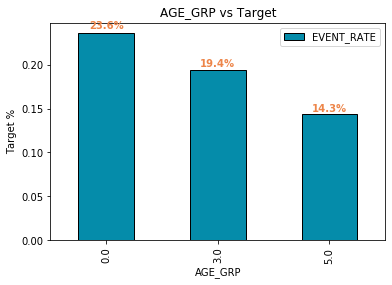

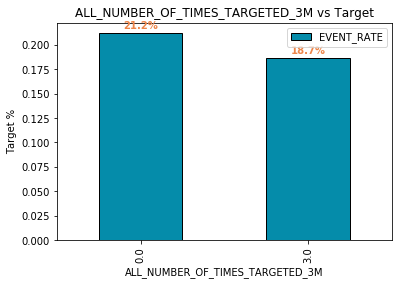

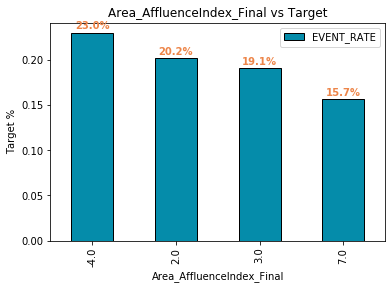

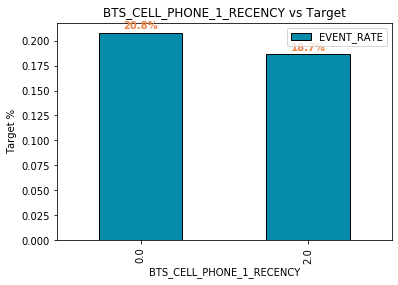

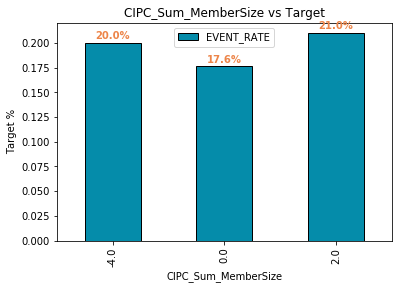

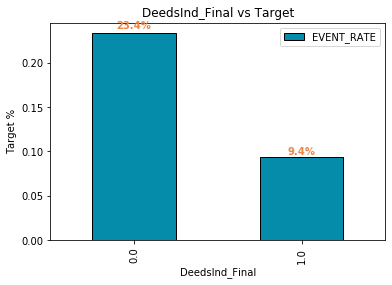

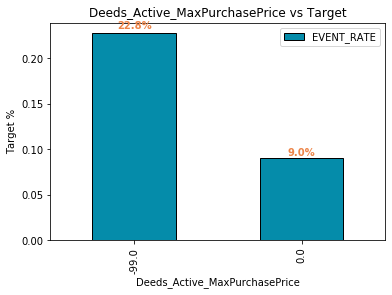

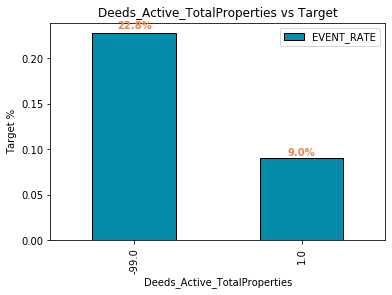

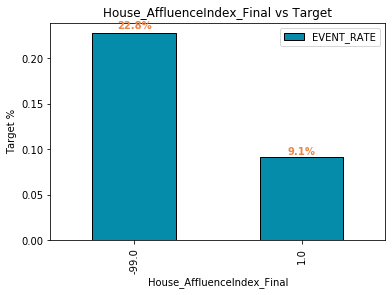

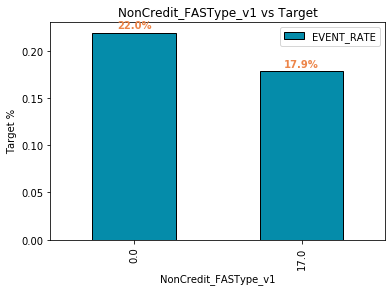

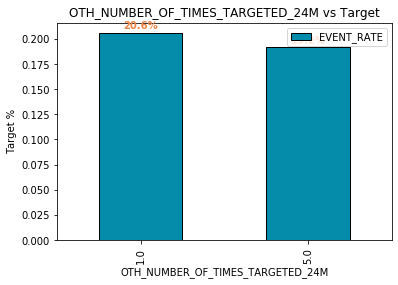

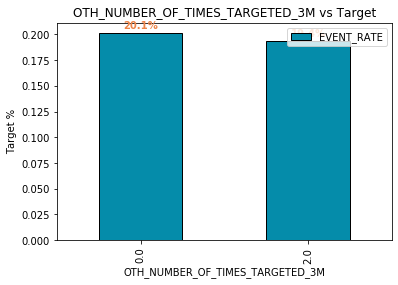

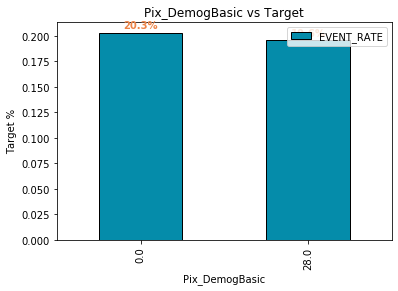

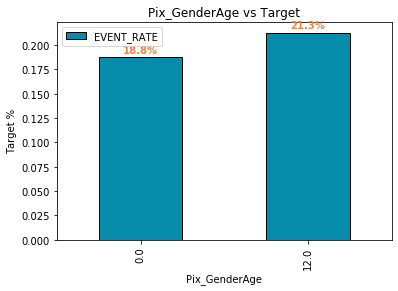

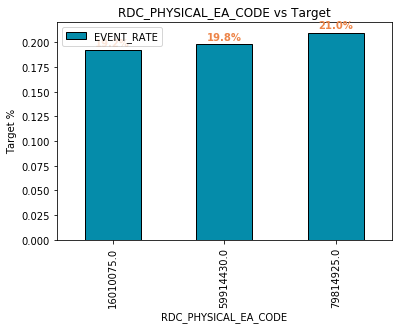

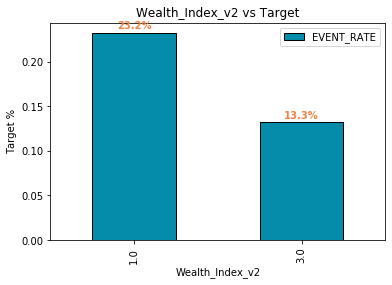

In [122]:
bar_color = '#058caa'
num_color = '#ed8549'

final_iv,_ = data_vars(df1,df1['Target'])
final_iv = final_iv[(final_iv.VAR_NAME != 'Target')]
grouped = final_iv.groupby(['VAR_NAME'])
for key, group in grouped:
    ax = group.plot('MIN_VALUE','EVENT_RATE',kind='bar',color=bar_color,linewidth=1.0,edgecolor=['black'])
    ax.set_title(str(key) + " vs " + str('Target'))
    ax.set_xlabel(key)
    ax.set_ylabel(str('Target') + " %")
    rects = ax.patches
    for rect in rects:
        height = rect.get_height()
        ax.text(rect.get_x()+rect.get_width()/2., 1.01*height, str(round(height*100,1)) + '%', 
                ha='center', va='bottom', color=num_color, fontweight='bold')

In [123]:
train, test = train_test_split(df1, test_size = 0.3)
train = train.reset_index(drop=True)
test = test.reset_index(drop=True)

features_train = train[list(vif['Features'])]
label_train = train['Target']
features_test = test[list(vif['Features'])]
label_test = test['Target']

In [127]:
from sklearn.ensemble import RandomForestClassifier
clf = RandomForestClassifier()

clf.fit(features_train,label_train)

pred_train = clf.predict(features_train)
pred_test = clf.predict(features_test)

from sklearn.metrics import accuracy_score
accuracy_train = accuracy_score(pred_train,label_train)
accuracy_test = accuracy_score(pred_test,label_test)

from sklearn import metrics
fpr, tpr, _ = metrics.roc_curve(np.array(label_train), clf.predict_proba(features_train)[:,1])
auc_train = metrics.auc(fpr,tpr)

fpr, tpr, _ = metrics.roc_curve(np.array(label_test), clf.predict_proba(features_test)[:,1])
auc_test = metrics.auc(fpr,tpr)

print(accuracy_train,accuracy_test,auc_train,auc_test)

C:\Users\C61166A\AppData\Local\Continuum\miniconda3\envs\ds_full\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


0.97235340756317 0.805968148426189 0.9974142630585963 0.6745712819607613


In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import GradientBoostingClassifier

n_estimators = [int(x) for x in np.linspace(start = 10, stop = 500, num = 10)]
max_features = ['auto', 'sqrt']
max_depth = [int(x) for x in np.linspace(3, 10, num = 1)]
max_depth.append(None)
min_samples_split = [2, 5, 10]
min_samples_leaf = [1, 2, 4]

grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf}

gb = GradientBoostingClassifier()

gf_tune = GridSearchCV(estimator = gb, param_grid = grid, cv = 2, verbose=2, n_jobs = -1)
gf_tune.fit(features_train, label_train)

print(gf_tune.best_params_)

Fitting 2 folds for each of 360 candidates, totalling 720 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:  7.3min
[Parallel(n_jobs=-1)]: Done 349 tasks      | elapsed: 12.8min


In [ ]:
from sklearn.ensemble import GradientBoostingClassifier
clf = GradientBoostingClassifier(**gf_tune.best_params_)

clf.fit(features_train,label_train)

pred_train = clf.predict(features_train)
pred_test = clf.predict(features_test)

from sklearn.metrics import accuracy_score
accuracy_train = accuracy_score(pred_train,label_train)
accuracy_test = accuracy_score(pred_test,label_test)

from sklearn import metrics
fpr, tpr, _ = metrics.roc_curve(np.array(label_train), clf.predict_proba(features_train)[:,1])
auc_train = metrics.auc(fpr,tpr)

fpr, tpr, _ = metrics.roc_curve(np.array(label_test), clf.predict_proba(features_test)[:,1])
auc_test = metrics.auc(fpr,tpr)

print(accuracy_train,accuracy_test,auc_train,auc_test)